# Natural Gas Energy Indicators – Datasets and Methodologies


## Importance of Energy Data:

Quality energy information is the foundation of informed discussion and decision-making by government, industry, and the Canadian public. It plays a key role in enhancing public confidence, economic competitiveness and the Government’s ability to support a transition to a low-carbon economy.

## Overview of Energy Information in Canada:
Energy information includes statistics, data, analysis and projections related to the production, transformation, distribution and consumption of energy; as well as the linkages between energy and the economy, society and environment.

Canada's energy information system is a collective contribution of several organizations, including:
- four federal departments or agencies:
  - Natural Resources Canada (NRCAN) [(link)](https://www.nrcan.gc.ca/home);
  - Statistics Canada [(link)](https://www.statcan.gc.ca/eng/start);
  - Environment and Climate Change Canada [(link)](https://www.ec.gc.ca/?lang=En);
  - Canada Energy Regulator (CER) [(link)](https://www.cer-rec.gc.ca/index-eng.html);
- provincial and territorial government departments, regulators and utilities boards;
- energy market participants (ex. power producers, pipeline companies, system operators, etc.);
- industry associations and academic research bodies;
- Canada’ Open Government website [(link)](https://open.canada.ca/en);
- __Canadian Energy Information Portal (launched in June 2019) [(link)](https://www.statcan.gc.ca/eng/topics-start/energy).__

## Canadian Energy Information Portal:
Although Canadian energy information is abundant, it can be difficult to navigate, interpret and verify, particularly for non-experts. Moreover, data measurements, definitions and reporting standards vary amongst information providers. Often, data is not available in structured and machine-readable formats. Finally, data releases are often not timely, and lags are considered too long for a growing demand for real-time information.

Recognizing the complexity of Canada’s current energy information system, in June 2019, the Government of Canada launched the Canadian Energy Information Portal [(link)](https://www.statcan.gc.ca/eng/topics-start/energy). The Hub is a one-stop shop for energy  information that provides a single point of access for all federal government statistics and provides links to existing body of energy information products.

## Goal of this notebook: 

- 1) Identify the main dataset featured in Canada’s natural gas market __[Energy Indicators](https://www.cer-rec.gc.ca/nrg/tl/nrgcmmdt/nrgndctrlctrct-eng.html)__;
- 2) Load each dataset used in the Energy Indicators into the Jupyter Notebook;
- 3) Chart each dataset;
- 4) Provide links to other publically-available datasets for more analysis.

__Datasets used in the Energy Indicators come from multiple, free, publicly-available sources. Dataset files themselves are not provided to accompany the Notebook. Rather, data is loaded directly into the Notebook from the source provider. This ensures transparency, reproducibility and timeliness for the user.__ 

__Datasets used in this Notebook are often not in a flat, machine-readable format. Also, measurement units between various datasets are not standardized. Therefore to provide analytical value, each dataset in the Notebook is transformed and standardized to ensure comparability.__

For units not available in this notebook, the Canada Energy Regulator offers a site with extensive energy conversion tables [(link)](https://apps.cer-rec.gc.ca/Conversion/conversion-tables.aspx?GoCTemplateCulture=en-CA). 

In [1]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup as bs
import zipfile
import io
import re
import requests
from matplotlib import pyplot as plt
from matplotlib.dates import DateFormatter
from pyxlsb import open_workbook
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

# set global parameters
sns.set_palette(sns.color_palette("tab20", 20))
register_matplotlib_converters()
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Energy Indicators - Natural Gas:

### Natural gas prices

#### 1) Main dataset
Natural gas is a globally traded commodity and has a highly developed and integrated market. Gas can be traded between buyers and sellers for an immediate or near-term delivery (for a spot price), or for a forward dated delivery (for a futures price). Spot and futures prices may vary depending on immediate and future expectations of market conditions. 

Daily spot [(link)](https://www.eia.gov/dnav/ng/hist/rngwhhdD.htm) and futures prices [(link)](https://www.eia.gov/dnav/ng/hist/rngc1d.htm) for natural gas are available from the U.S. Energy Information Administration and are updated daily.  

Alberta natural gas prices are published by the Government of Alberta [(link)](https://economicdashboard.alberta.ca/NaturalGasPrice).

#### 2) Load dataset

In [2]:
# download EIA Henry Hub spot price
url_hh = 'https://www.eia.gov/dnav/ng/hist_xls/RNGWHHDm.xls'
sheet_hh = 'Data 1'
df_hh = pd.read_excel(url_hh, sheet_name=sheet_hh, index_col=None, header=2, parse_dates=['Date'])
df_hh['Date'] = df_hh['Date'].values.astype('datetime64[M]')
df_hh.set_index('Date', inplace=True)
df_hh['Henry Hub (US$/GJ)'] = df_hh['Henry Hub Natural Gas Spot Price (Dollars per Million Btu)'] * 1.05505585

# download CN/US exchange rate from the federal reserve (US)
url_fed = 'https://www.federalreserve.gov/releases/h10/hist/dat00_ca.htm'
df_fed = pd.read_html(url_fed, index_col=['Date'], header=0, parse_dates=['Date'])[0]
df_fed['Rate'] = pd.to_numeric(df_fed['Rate'], errors='coerce')
df_fed = df_fed.resample('MS').mean()

# we are using the Fed Reserve exchange rate (above), but BofC exchange rate is another option
# download CN/US exchange rate from Bank Of Canada
# url_boc = 'https://www.bankofcanada.ca/valet/observations/FXUSDCAD/csv'
# df_boc = pd.read_csv(url_boc, index_col=['date'], header=6, parse_dates=['date'])
# df_boc = df_boc.resample('MS').mean()
# df_boc.index.rename('Date', inplace=True)

# access Alberta natural gas prices
url_ab = 'https://economicdashboard.alberta.ca/Download/DownloadFile?extension=csv&requestUrl=https%3A%2F%2Feconomicdashboard.alberta.ca%2Fapi%2FOilPrice'
df_ab = pd.read_csv(url_ab, index_col='When', header=0, parse_dates=['When']).rename(columns={'Alberta':'Alberta (CN$/GJ)'})
df_ab.index.rename('Date', inplace=True)
df_ab = df_ab[df_ab['Type'] == 'NatGas'][['Alberta (CN$/GJ)']]

# merge all prices and exchange rates
df_prices = df_ab.merge(df_hh[['Henry Hub (US$/GJ)']], 'left', on='Date').merge(df_fed, how='left', on='Date') # .merge(df_boc, 'left', on='Date')
df_prices['Henry Hub (CN$/GJ)'] = df_prices['Henry Hub (US$/GJ)'] * df_prices['Rate']
df_prices = df_prices[df_prices.index.year >= 2016][['Alberta (CN$/GJ)', 'Henry Hub (CN$/GJ)']]

#### 3) Chart dataset

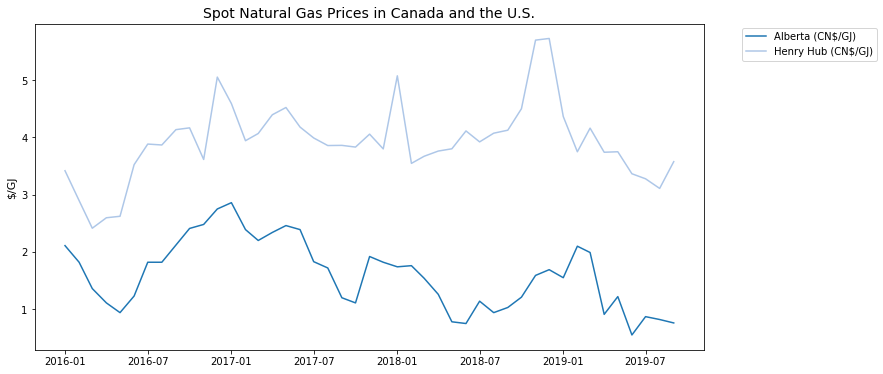

In [3]:
fig, (ax1) = plt.subplots(ncols=1, nrows=1, figsize=(12,6))

ax1.plot(df_prices.index, df_prices)
ax1.set_ylabel('$/GJ', fontsize=11)
ax1.set_title('Spot Natural Gas Prices in Canada and the U.S.', fontsize=14)
ax1.legend(df_prices.columns, fontsize=10, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.4);

#### 4) Other datasets for Canadian natural gas prices

Natural gas prices for Canadian customers are also available from local natural gas distribution companies or provincial utility regulators.
This price data is often filed to utility regulators for review to ensure prudent gas supply.  
- Alberta natural gas prices are provided by the Alberta Utilities Commission [(link)](http://www.auc.ab.ca/pages/current-rates-gas.aspx);
- British Columbia natural gas prices are available from FortisBC [(link)](https://www.fortisbc.com/accounts-billing/billing-rates/natural-gas-rates/residential-rates);
- Saskatchewan natural gas prices are available from SaskEnergy [(link)](https://www.saskenergy.com/residential/resrates_hist.asp);
- Manitoba natural gas prices are provided by the Manitoba Public Utilities Board [(link)](http://www.pubmanitoba.ca/v1/regulated-utilities/natural-gas/rates/s_supply.html)
- Ontario natural gas prices are provided by the Ontario Energy Board [(link)](https://www.oeb.ca/rates-and-your-bill/natural-gas-rates);
- Québec natural gas prices are available from Energir [(link)](https://www.energir.com/en/business/price/natural-gas-price/);
- New Brunswick natural gas prices are available from Enbridge Gas New Brunswick [(link)](https://naturalgasnb.com/en/for-home/accounts-billing/our-product-offering/#eug-rate-history);
- Nova Scotia natural gas prices are available from Heritage Gas [(link)](http://www.heritagegas.com/natural-gas/historical-rates/).

### Natural gas production

#### 1) Main dataset
Data on the production of natural gas is collected by provincial governments and is used to assess the collection of royalties or support regulatory mandates. The CER aggregates provincial government statistics and publishes the _Marketable Natural Gas Production in Canada_ report [(link)](https://www.cer-rec.gc.ca/nrg/sttstc/ntrlgs/stt/mrktblntrlgsprdctn-eng.html). Data is available since 2000 and is updated by the CER monthly. Provincial government data may be delayed by up to 6 months. Definition of 'marketable production' is variable between sources.

More specifically, the CER aggregates the following province-level statistics:
- Government of British Columbia - Production and distribution of Natural Gas in BC report [(link)](http://www2.gov.bc.ca/gov/content/industry/natural-gas-oil/statistics);

    _Marketable Production = Residue Gas plant outlet - BC production only_
    
    
- Alberta Energy Regulator - ST3: Alberta Energy Resource Industries Monthly Statistics [(link)](https://aer.ca/providing-information/data-and-reports/statistical-reports/st3);

     _Marketable Production = Well Production + In Situ Well Production – flared – vented – shrinkage_ 
     
     
- Government of Saskatchewan  - Natural Gas Volume and Value Summary report [(link)](http://publications.gov.sk.ca/details.cfm?p=89506);

     _Marketable Production = Gas Available for Use or Sale_


- Canada - Nova Scotia Offshore Petroleum Board - Monthly Production Summary report [(link)](http://www.cnsopb.ns.ca/offshore-activity/weekly-activity-reports);

    _Marketable Production = raw gas production * 92.5_
    
    
- Government of New Brunswick – Monthly Production Statistics report [(link)](http://www2.gnb.ca/content/dam/gnb/Departments/en/pdf/Minerals-Minerales/Monthly_Statistics.pdf);

    _Marketable Production = Natural Gas_
    

- Statistics Canada CANSIM – Supply and disposition of natural gas, monthly report [(link)](https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=2510005501);

    _Marketable Production for Ontario = Reported Data_
    
    
- Northern Canada:
 -  CER _North/Offshore Statistics_ [(link)](https://www.cer-rec.gc.ca/nrth/sttstc/index-eng.html);
 -  Government of Northwest Territories Bureau of Statistics Oil and Gas [(link)](https://www.statsnwt.ca/economy/oil-gas/).




#### 2) Load dataset to notebook

In [4]:
# access data from the Marketable Natural Gas Production in Canada report (published by the Canada Energy Regulator)

url_cer = 'https://www.cer-rec.gc.ca/nrg/sttstc/ntrlgs/stt/mrktblntrlgsprdctn-eng.html'  
sheet_prod = '2000+ - cubic feet per day'

r = requests.get(url_cer)
if r.status_code == 200:
    soup = bs(r.content, 'lxml')
    # find the most recent dataset
    y = 0
    links = soup.find_all('a', attrs={'href': re.compile('^/nrg/sttstc/ntrlgs/stt/(.)*.xlsx?')})
    for link in links:
        new_y = int(link.get('href').split('.')[-2][-4:])
        if y < new_y:
            y = new_y
            url_prod = 'https://www.cer-rec.gc.ca' + link.get('href')
     
    df_prod = pd.read_excel(url_prod, sheet_name=sheet_prod, usecols='A:K', header=8, index_col=0, 
                            parse_dates=['Date']).dropna(1, 'all').dropna(0, 'all') / 1000
    df_prod.rename(columns={'NS':'Nova Scotia', 'NB':'New Brunswick', 'Sask':'Saskatchewan', 'BC':'British Columbia'}, 
                   inplace=True)
    df_prod = df_prod[df_prod.index.year >= 2016].dropna(0, 'any', subset=['Canada']).fillna(0)
else:
    print('Could not access CER page: ', url_cer)

#### 3) Chart dataset

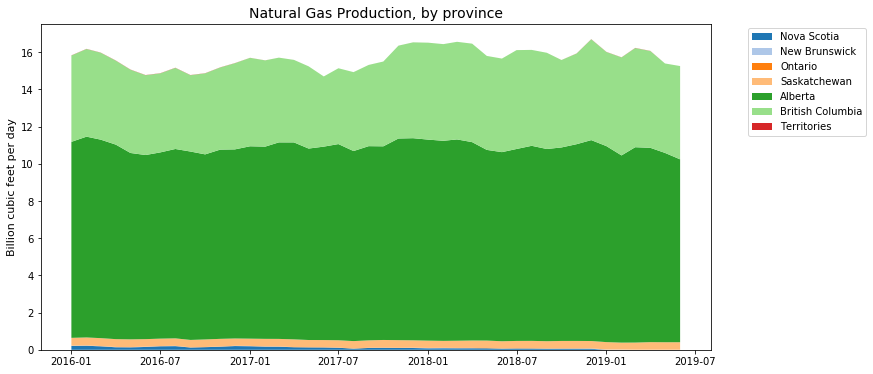

In [5]:
fig, (ax1) = plt.subplots(ncols=1, nrows=1, figsize=(12,6))

ax1.stackplot(df_prod.index, df_prod.drop('Canada', 1).T)
ax1.set_ylabel('Billion cubic feet per day', fontsize=11)
ax1.set_title('Natural Gas Production, by province', fontsize=14)
ax1.legend(df_prod.drop('Canada', 1).columns, fontsize=10, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.4);

Alberta is the largest producer of natural gas in Canada, followed by British Columbia and Saskatchewan. Together, the three provinces produce 99 per cent of Canada's total production. 

#### 4) Other datasets for Canadian natural gas production


Monthly natural gas production data is available from Statistics Canada's
_Supply and disposition of natural gas, Table 25-10-0055-01_ [(link)](https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=2510005501). This report employs a different methodology to calculate production of marketable gas compared to the CER, and therefore the data between the two reports is not identical. Production volumes in the _Supply and disposition of natural gas report_ are based on survey and administrative data.

### Natural Gas Demand
#### 1) Main dataset
Statistics Canada publishes _Supply and disposition of natural gas (CANSIM Table 25-10-0055-01)_ [(link)](https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=2510005501). This monthly report provides demand data for residential, commercial and industrial customer classes, and by province.

#### 2) Load dataset

In [6]:
# Statistics Canada table 25100055, "Supply and disposition of natural gas, monthly"
# extract csv from a zip file
url_demand = 'https://www150.statcan.gc.ca/n1/tbl/csv/25100055-eng.zip'
file_name = '25100055.csv'
r = requests.get(url_demand, allow_redirects=True)
zip_file = zipfile.ZipFile(io.BytesIO(r.content))
df_demand_all = pd.read_csv(zip_file.open(file_name), index_col=None, header=0, parse_dates=['REF_DATE'])

# filter for end-use demand in cubic metres
keep = ['Residential consumption', 'Industrial consumption', 'Commercial consumption']
df_demand = df_demand_all[df_demand_all['Supply and disposition'].isin(keep) 
                          & (df_demand_all['UOM'] == 'Cubic metres')][['REF_DATE', 'GEO', 'Supply and disposition', 'VALUE']]

# clean up
df_demand['Value (Bcf/d)'] = df_demand['VALUE']/(df_demand['REF_DATE'].dt.daysinmonth) / 1000000 * 35.3147 # convert to bcf/d
df_demand.rename(columns={'REF_DATE':'Date', 'GEO':'Region', 'Supply and disposition':'Category'}, inplace=True)
df_demand_prov = df_demand.pivot_table(index='Date', columns='Region', aggfunc=np.sum)['Value (Bcf/d)']
df_demand_prov.columns = df_demand_prov.columns.str.replace('Northwest Territories', 'Territories')

#### 3) Chart dataset

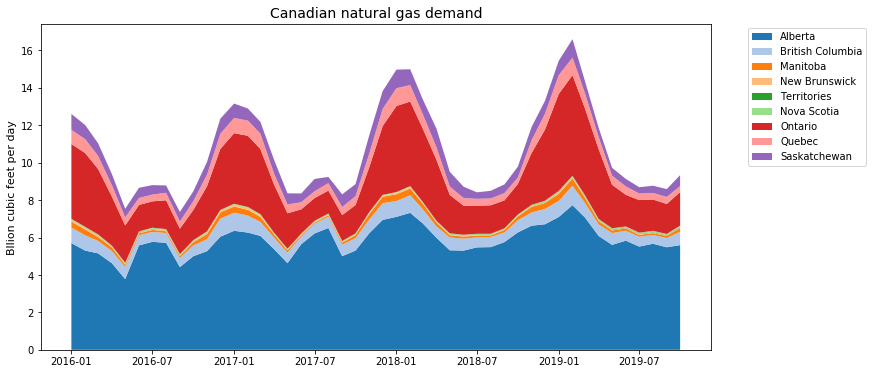

In [7]:
fig, (ax1) = plt.subplots(ncols=1, nrows=1, figsize=(12,6))

ax1.stackplot(df_demand_prov.index, df_demand_prov.drop('Canada', 1).T)
ax1.set_ylabel('Bllion cubic feet per day', fontsize=11)
ax1.set_title('Canadian natural gas demand', fontsize=14)
ax1.legend(df_demand_prov.drop('Canada', 1).columns, fontsize=10, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.4);

Canadian natural gas demand is seasonal. Demand is highest in the winter when natural gas is used for space heating. The largest natural gas user in Canada is the industrial sector, which includes industries such as crude oil extraction and processing, petrochemicals, manufacturing and power production. Alberta is the largest user of natural gas, followed by Ontario and Saskatchewan. 

#### 4) Other datasets for natural gas demand


Publically available real-time daily data on natural gas demand is not available.

The government of British Columbia publishes a monthly natural gas production and distribution report, which includes sales to three gas utilities - Fortis BC, Pacific Northern Gas, and Pacific Northern Gas (NE). Data is also available by four classes of customers (direct, residential, commercial and industrial) [(link)](https://www2.gov.bc.ca/assets/gov/farming-natural-resources-and-industry/natural-gas-oil/production-statistics/gasnew.xls).

The Alberta Energy Regulator publishes a monthly natural gas supply and disposition report, which includes provincial demand by customer class, consumption by large industrial facilities, injections and removals [(link)](https://www.aer.ca/providing-information/data-and-reports/statistical-reports/st3).

Annual natural gas demand data by sector is available from Statistics Canada’s overall energy balances, _Supply and demand of primary and secondary energy in terajoules Table 25-10-0029-01_ [(link)](https://www150.statcan.gc.ca/t1/tbl1/en/cv.action?pid=2510002901). This report includes data in energy units (terajoules), which allows across fuel comparisons and summation. Statistics Canada also publishes _Supply and demand of primary and secondary energy in natural units Table 25-10-0030-01_ [(link)](https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=2510003001). This report contains the same data but in natural units, which vary by energy type (litres for liquid fuel, GWh for electricity, etc.) and therefore are not always additive or directly comparable across fuel types [(link)](https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=2510003001).

Annual natural gas demand by province and sector is also available from the CER _Energy Futures_ report [(link)](http://apps.neb-one.gc.ca/nrg/ntgrtd/ftr/2016/index-eng.html). Statistics Canada and CER employ different methodologies in deriving annual natural gas demand.  

Detailed demand data for natural gas and other other energy commodities in available from NRCAN's _Comprehensive Energy Use Database_. The Database provides an overview of energy use in Canada by sector (commercial, residental, industrial, transportation and agriculture) and in each region of the country [(link)](http://oee.nrcan.gc.ca/corporate/statistics/neud/dpa/menus/trends/comprehensive_tables/list.cfm).

Canadian pipeline companies publish daily gas day summary reports on their websites, which aggregate pipeline users' daily nominations. Review of this data may provide an indication of daily natural gas demand in a specific region. Major pipelines that provide gas day summary reports include: 
- TransCanada Mainline pipeline [(link)](http://www.tccustomerexpress.com/2878.html);
- Nova Gas Transmission pipeline [(link)](http://www.tccustomerexpress.com/2878.html);
- Westcoast pipeline [(link)](https://noms.wei-pipeline.com/customer-activities/pipeline.php);
- Union Gas pipeline [(link)](https://www.uniongas.com/storage-and-transportation/informational-postings/gas-day-summary);
- TransGas pipeline [(link)](https://www.transgas.com/infopostings/apps/DailyOpsDetail.aspx);

### Natural gas exports
#### 1) Main dataset

Canada produces more natural gas than is required for domestic consumption. Remaining natural gas is exported to the United States via pipelines. The Canada Energy Regulator (CER) regulates the imports and exports of natural gas and collects import and export statistics from pipeline users. This information is available from the CER's Commodities Tracking System (__[link](https://apps.neb-one.gc.ca/CommodityStatistics/Statistics.aspx?language=english)__) and in flat format from Canada's Open Government website [(link)](https://open.canada.ca/data/en/dataset/b2f35cd0-4e54-4960-bdb1-7b040f5beaa0).

#### 2) Load dataset

In [8]:
# access Natural Gas Exports and Imports data
url_trade = 'https://www.cer-rec.gc.ca/open/imports-exports/natural-gas-exports-and-imports-monthly.csv'
df_trade = pd.read_csv(url_trade, index_col='Period', header=0, parse_dates=['Period']) 
df_trade.index.rename('Date', inplace=True)

# assign province to each port
provinces = {'Aden':'Alberta', 'Armstrong':'Quebec', 'Blaine':'British Columbia', 'Brunswick':'New Brunswick',
             'Canaport':'New Brunswick', 'Cardston':'Alberta', 'Champlain':'Quebec', 'Chippawa':'Ontario','Cornwall':'Ontario', 
             'Corunna':'Ontario', 'Courtright':'Ontario', 'Coutts':'Alberta', 'East Hereford':'Quebec', 
             'Elmore':'Saskatchewan', 'Emerson':'Manitoba', 'Fort Frances':'Ontario', 'Highgate Springs':'Quebec', 
             'Highwater':'Quebec', 'Huntingdon':'British Columbia', 'Iroquois':'Ontario', 'Kingsgate':'British Columbia', 
             'Loomis':'Saskatchewan', 'Monchy':'Saskatchewan','Napierville':'Quebec','Niagara Falls':'Ontario', 
             'North Portal':'Saskatchewan', 'Ojibway':'Ontario', 'Ojibway (Windsor)':'Ontario', 'Philipsburg':'Quebec', 
             'Port of Estevan':'Saskatchewan', 'Rainy River':'Ontario', 'Reagan Field':'Alberta', 'Sarnia':'Ontario', 
             'Sarnia/Blue Water':'Ontario', 'Sault Ste Marie':'Ontario', 'Sierra':'Alberta', 'Sprague':'Manitoba', 
             'St Clair':'Ontario', 'St Stephen':'New Brunswick','Willow Creek':'Saskatchewan','Windsor (Ojibway)':'Ontario', 
             'Total':'Canada'}
df_trade['Province'] = df_trade['Port'].map(provinces)

df_trade['Volume (Bcf/d)'] = df_trade['Volume (MCF)'] / 1000000 / (df_trade.index.days_in_month)
df_trade = df_trade[df_trade.index.year >= 2016][['Flow', 'Province', 'Volume (Bcf/d)']]

# get exports by province
df_exports = df_trade[df_trade['Flow'] == 'Exports'].pivot_table(index='Date', columns='Province', 
                                                                 aggfunc=np.sum)['Volume (Bcf/d)'].fillna(0)

#### 3) Chart dataset

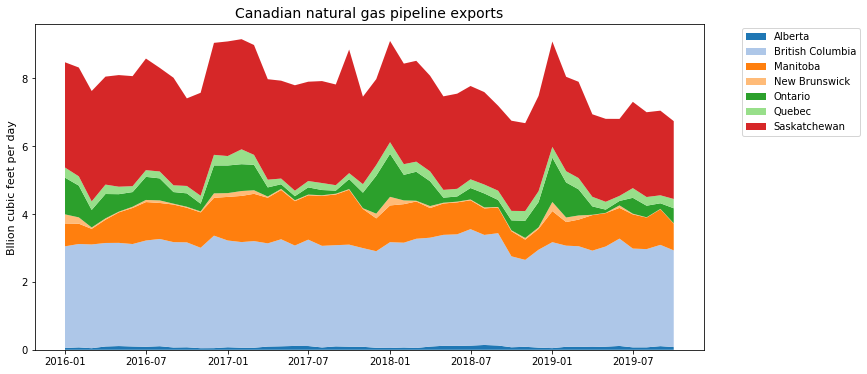

In [9]:
fig, (ax1) = plt.subplots(ncols=1, nrows=1, figsize=(12,6))

ax1.stackplot(df_exports.index, df_exports.drop('Canada', 1).T)
ax1.set_ylabel('Bllion cubic feet per day', fontsize=11)
ax1.set_title('Canadian natural gas pipeline exports', fontsize=14)
ax1.legend(df_exports.drop('Canada', 1).columns, fontsize=10, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.4); 

Approximately half of Canada's natural gas production is exported to various markets in the United States via pipelines. The four main exporting provinces (where pipelines cross the Canada-US border) are British Columbia, Saskatchewan, Manitoba and Alberta. Provinces that produce little or no natural gas can still export significant amounts, because pipelines pass through these provinces to reach export markets.

#### 4) Other datasets for natural gas exports

Data on natural gas exports quantity and values by trading country can also be found in the Canadian International Merchandise and Trade (CIMT) database [(link)](https://www5.statcan.gc.ca/cimt-cicm/home-accueil?lang=eng). This report is based on customs-based trade data, which are derived from the administrative records of the Canadian Border Services Agency and the United States Customs Border Protection. The Harmonized System (HS) code for *natural gas* is 27112100. 

Statistics Canada publishes _Supply and disposition of natural gas (CANSIM Table 25-10-0055-01)_ [(link)](https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=2510005501). This monthly report provides monthly exports data, by province. Exports volumes in the _Supply and disposition of natural gas_ report are based on survey and administrative data.

Both of these reports employ a different methodology to calculate imports and exports compared to the CER, and therefore the data between the three reports is not identical.

### Natural gas imports
#### 1) Main dataset

Natural gas import information is available from the CER's Commodities Tracking System (__[link](https://apps.neb-one.gc.ca/CommodityStatistics/Statistics.aspx?language=english)__) and in flat format from Canada's Open Government website [(link)](https://open.canada.ca/data/en/dataset/b2f35cd0-4e54-4960-bdb1-7b040f5beaa0).

#### 2) Load dataset

In [10]:
# all the data for flows was download in the above section into df_flows, get the imports from the data
df_imports = df_trade[df_trade['Flow'] == 'Imports'].pivot_table(index='Date', columns='Province', 
                                                                 aggfunc=np.sum)['Volume (Bcf/d)'].fillna(0)

#### 3) Chart dataset

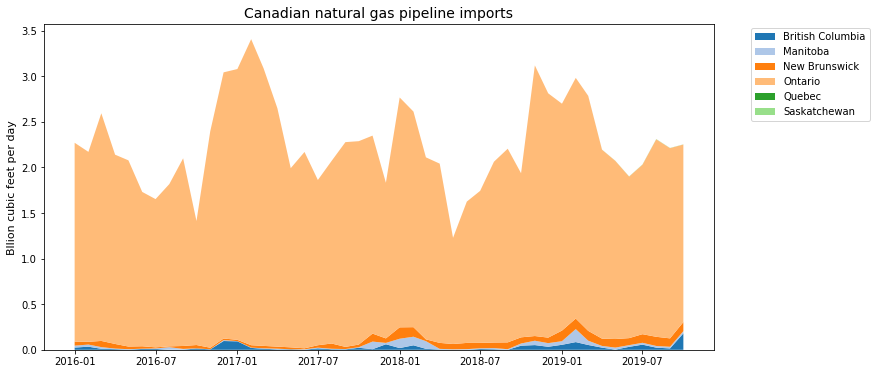

In [11]:
fig, (ax1) = plt.subplots(ncols=1, nrows=1, figsize=(12,6))

ax1.stackplot(df_imports.index, df_imports.drop('Canada', 1).T)
ax1.set_ylabel('Bllion cubic feet per day', fontsize=11)
ax1.set_title('Canadian natural gas pipeline imports', fontsize=14)
ax1.legend(df_imports.drop('Canada', 1).columns, fontsize=10, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.4); 

#### 4) Other datasets for natural gas imports

Data on natural gas imports quantity and values by trading country can also be found in the Canadian International Merchandise and Trade (CIMT) database [(link)](https://www5.statcan.gc.ca/cimt-cicm/home-accueil?lang=eng). This report is based on customs-based trade data, which are derived from the administrative records of the Canadian Border Services Agency and the United States Customs Border Protection. The Harmonized System (HS) code for *natural gas* is 27112100. 

Statistics Canada publishes _Supply and disposition of natural gas (CANSIM Table 25-10-0055-01)_ [(link)](https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=2510005501). This monthly report provides monthly imports data, by province. Import volumes in the _Supply and disposition of natural gas_ report are based on survey and administrative data.

### Rig Count
#### 1) Main dataset
The rig count shows how many rigs are drilling for gas, and gives a reasonable indication of industry expectations of gas demand and prices. The rig count depends on weather and is highly seasonal - activity is highest during winter, when the ground is frozen and rigs can move to most places.

Baker Hughes is a large crude oil and natural gas extraction services company. Baker Hughes releases the North American rig count in a weekly report [(link)](http://phx.corporate-ir.net/phoenix.zhtml?c=79687&p=irol-reportsother). 

#### 2) Load dataset

In [12]:
# access data (Baker Hughes Summary)
# this data is in xlsb (Excel Binary) format
url_bh = 'https://bakerhughesrigcount.gcs-web.com/na-rig-count'
sheet_rigs = 'Canada Oil & Gas Split'

r = requests.get(url_bh)
if r.status_code == 200:
    soup = bs(r.content, 'lxml')
    url_rigs = soup.find('a', text=re.compile('^North America Rotary Rig Count \(')).get('href')

    r = requests.get(url_rigs)
    if r.status_code == 200:
        data_rigs = []
        with open_workbook(io.BytesIO(r.content)) as wb:
            with wb.get_sheet(sheet_rigs) as ws:
                # regions are in row 6, labels in row 7, data in rows 8, etc.
                for row in ws.rows():
                    if row[0].r == 6:
                        products = [item.v for item in row]
                    elif row[0].r > 6:
                        data_rigs.append([item.v for item in row])

            products = products[:-2] + [p + ' Percent of Total' for p in products[-2:]]
            df_rigs = pd.DataFrame(data_rigs, columns=products, index=None).dropna(1, 'all').dropna(0, 'all')
            df_rigs['DATE'] = pd.to_datetime(df_rigs['DATE'], unit='d', origin='1899-12-30')
            df_rigs.set_index('DATE', inplace=True)
    else:
        print('Could not access Rig Count Summary file: ', url_rigs)
    df_rigs = df_rigs[(df_rigs.index.year >= 2016)]
else:
    print('Could not access Baker Hughes page: ', url_bh)

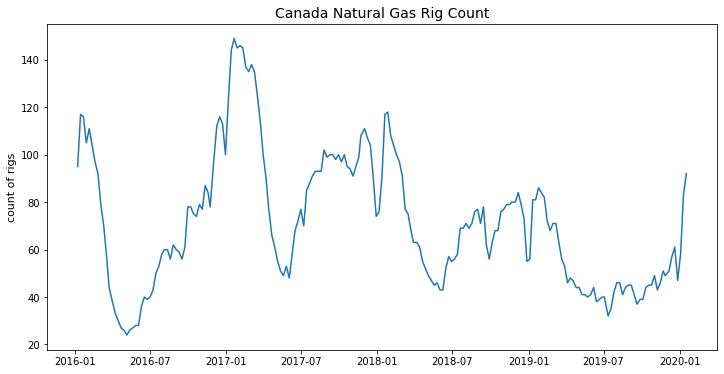

In [13]:
fig, (ax1) = plt.subplots(ncols=1, nrows=1, figsize=(12,6))
ax1.plot(df_rigs.index, df_rigs['GAS']) 
ax1.set_ylabel('count of rigs', fontsize=11)
ax1.set_title('Canada Natural Gas Rig Count', fontsize=14);

In [14]:
# access data (Baker Hughes Detail)
# this data is in xlsb (Excel Binary) format
#2 min run time
url_bh = 'https://bakerhughesrigcount.gcs-web.com/na-rig-count'
sheet_rigs = 'Master Data'

r = requests.get(url_bh)
if r.status_code == 200:
    soup = bs(r.content, 'lxml')
    url_rigs = soup.find('a', text=re.compile('^North America Rotary Rig Count Pivot Table \(')).get('href')
    r = requests.get(url_rigs)
    if r.status_code == 200:
    
        data_rigs = []
        with open_workbook(io.BytesIO(r.content)) as wb:
            with wb.get_sheet(sheet_rigs) as ws:
                for row in ws.rows():
                    data_rigs.append([item.v for item in row])
        df_rigs = pd.DataFrame(data_rigs[1:], columns=data_rigs[0], index=None).dropna(1, 'all').dropna(0, 'all')
        df_rigs['DATE'] = pd.to_datetime(df_rigs['PublishDate'], unit='d', origin='1899-12-30')
        df_rigs = df_rigs[(df_rigs['Country'] == 'CANADA') & (df_rigs['DrillFor'] == 'Gas') 
                          & (df_rigs['Year'] >= 2016)][['DATE', 'State/Province', 'RigCount']]
        df_rigs = df_rigs.groupby(['DATE', 'State/Province']).sum().reset_index()
        df_rigs = df_rigs.pivot_table(index='DATE', columns='State/Province', aggfunc=np.sum)['RigCount']
    else:
        print('Could not access Rig Count Detail file: ', url_rigs)
else:
    print('Could not access Baker Hughes page: ', url_bh)

### 3) Chart dataset:

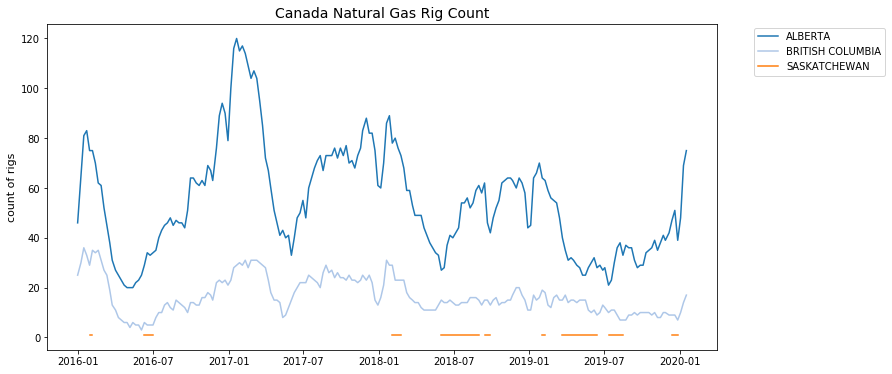

In [15]:
fig, (ax1) = plt.subplots(ncols=1, nrows=1, figsize=(12,6))
ax1.plot(df_rigs.index, df_rigs) 
ax1.set_ylabel('count of rigs', fontsize=11)
ax1.set_title('Canada Natural Gas Rig Count', fontsize=14) 
ax1.legend(df_rigs.columns, fontsize=10, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.4); 

The largest number of rigs in Canada are located in Alberta, where majority of Canadian natural gas production comes from. Rig activity has significantly decreased since 2008, because companies have switched from drilling low productivity, vertical wells to drilling high productivity, horizontal wells. Over time, rig activity has tended to continue falling, because companies have increased their efficiencies, enabling the same rigs to drill more distance in the same amount of time.

### Natural gas supply and demand projection

#### 1) Main dataset

The Canada Energy Regulator publishes the _Energy Futures_ report [(link)](https://www.cer-rec.gc.ca/nrg/ntgrtd/ftr/2019/index-eng.html) - a projection of Canadian energy supply and demand to 2040. The report includes projections for supply and demand of natural gas. Projections are modeled based on historical data, and include a series of policy, technology and market assumptions outlined in the report. The report provides data appendices [(link)](https://apps.neb-one.gc.ca/ftrppndc/dflt.aspx?GoCTemplateCulture=en-CA) and interactive visualizations [(link)](https://apps2.cer-rec.gc.ca/dvs/?page=landingPage&language=en) to further explore Canada's energy future. The latest _Energy Futures_ report was published in December 2019.

#### 2) Load dataset

In [16]:
# access data 
url_ef = 'https://www.cer-rec.gc.ca/nrg/ntgrtd/ftr/2019/ccssndxplr/fgrs-eng.xlsx'
sheet_gas = '22'
df_ef_gas = pd.read_excel(url_ef, sheet_name=sheet_gas, header=4, index_col=0).rename(columns = {'Net Exports':'Net Pipeline Exports'})

#### 3) Chart dataset

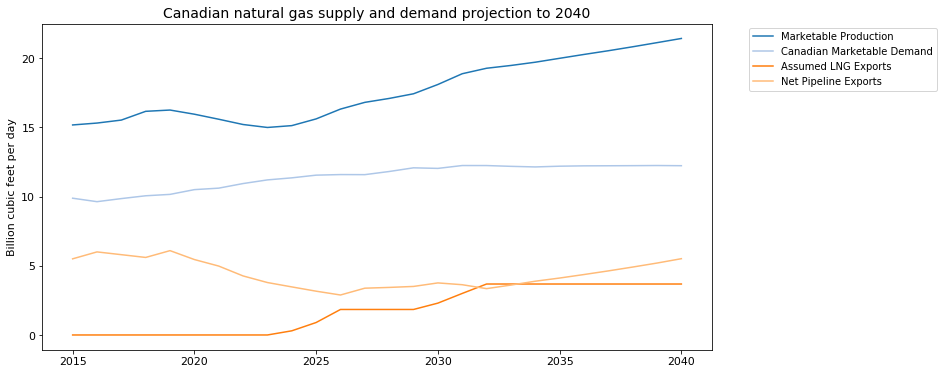

In [17]:
fig, ax = plt.subplots(ncols=1, figsize=(12,6))
ax.plot(df_ef_gas)
ax.set_title('Canadian natural gas supply and demand projection to 2040', fontsize = 14)
ax.legend(df_ef_gas.columns, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.4, fontsize = 10) 
ax.set_ylabel('Billion cubic feet per day', fontsize = 11)
ax.tick_params(labelsize = 11);

Canada's natural gas supply is projected to come primarily from two provinces - Alberta and British Columbia. As production ramps up after 2023, production growth starts to outpace demand growth and net export rise. By 2025, export of liquified natural gas begin to contribute to the growth in net exports. By 2040, natural gas production in Canada is projected to reach 21 billion cubic feet per day. 

#### 4) Other datasets for Canadian natural gas supply and demand projections
The Alberta Energy Regulator publishes the _ST98 Report_, a projection of natural gas production in Alberta [(link)](https://www.aer.ca/providing-information/data-and-reports/statistical-reports/st98). 

At the international level, other government, non-government and corporate bodies publish global energy supply and demand statistics, which includes Canada. These include:
- US Energy Information Administration's _International Energy Outlook 2018_ [(link)](https://www.eia.gov/outlooks/ieo/);
- International Energy Agency _World Energy Outlook_ [(link)](https://www.iea.org/weo/);
- Asia Pacific Energy Research Centre’s (APERC) _Energy Demand and Supply Outlook_ [(link)](https://aperc.ieej.or.jp/publications/reports/outlook.php);
- _BP Energy Outlook_ [(link)](https://www.bp.com/en/global/corporate/energy-economics/energy-outlook.html).

## Additional Resources
Please see the Canadian Energy Information Inventory (CCEI), a government maintained searchable database for energy-related information and datasets in Canada. The CEII contains url links to over 200 datasets related to energy use and production in Canada and is searchable by issuer, commodity and category [(link)](https://public.tableau.com/profile/energy.markets#!/vizhome/CanadianEnergyInformationInventoryCEII-V2_0/Datasets).

All the datasets used in this notebook are listed in the CEII. To provide feedback on the CEII, please email CEII-ICIE@cer-rec.gc.ca.

The Canadian Association of Petroleum Producers publishes the _Statistical Handbook for Canada’s Upstream Petroleum
Industry_. The Handbook is a historical summary of the petroleum industry's progress and summarizes detailed statistical information on prices, drilling, reserves, production and trade [(link)](https://www.capp.ca/publications-and-statistics/statistics/statistical-handbook).  